In [198]:
import OSGridConverter #To convert from =SGB36 to WGS84
import pandas as pd #To use pandas for elegant data handling
import numpy as np
import math
import plotly.express as px

We read in the data first

In [126]:
geograph = pd.read_csv('./data/geograph_mini_corpus.csv', encoding='latin-1')
        
#sample = geograph.sample(n = 1000) # For testing
sample = geograph

print(f'The initial corpus contains {len(sample)} documents.')

The initial corpus contains 138639 documents.


Create the three indexes we need:

- The spatial index stores documents in square cells and allows us to perform a range query
- The postings index indexes terms and the documents in which they are found
- The gazetteer indexes toponyms and allows us to look them up

The spatial index takes a resolution as a parameter
The postings file is restricted to terms from this [paper](https://firstmonday.org/ojs/index.php/fm/article/view/3710/3035) if the argument is true. If false then all terms (including stop words) are indexed.

Building these indexes takes time, but only needs to be done once.

In [ ]:
resolution = 10000
limitedTerms = True
si = SpatialIndex(resolution, sample)
postings = Postings(limitedTerms, sample)
gaz = Gazetteer()

Demonstrates a look up in the gazetteer. For some toponym types point and bounding box are returned. Bounding box could be used to exlude documents for near queries.

In [206]:
name = 'Ben Nevis'
location = gaz.getLocation(name)
print(location)

['Ben Nevis' 771500 216500 'Highland' 'H']
(216500, 771500, 216250, 771250, 216750, 771750)


Find all documents within a bounding box "centred" around the location returned from the gazetteer. Documents are returned with their distances and ranked according to distance from toponym. 

In [207]:
maxDist = 100000
docsSpatial = si.rangeQuery(maxDist, (location[0],location[1]))
print(f'Found {len(docsSpatial)} documents in a {maxDist}m x {maxDist}m around {name}.')

Found 3220 documents in a 100000m x 100000m around Ben Nevis.


Do a query and return documents ranked by tf-idf scores in the corpus.

In [218]:
query = 'hill beach loch'
docsThematic = postings.tfIdf(query)
maxThematic = next(iter(docsThematic.items()))[1] # Used to normalise scores
print(f'Found {len(docsThematic)} documents using the query: {query}')

Found 21047 documents using the query: hill beach loch


Find the unique documents from both sets. Typically there will be some duplicates.

In [219]:
#Create a set of unique keys for all the documents retrieved from the thematic and spatial indexes
candidates = set(list(docsSpatial.keys()) + list(docsThematic.keys()))

print(f'Found {len(candidates)} unique documents merging the thematic and spatial indexes')

Found 23250 unique documents merging the thematic and spatial indexes


Rank documents according to spatial (distance) and thematic (tf-idf) scores. 'wspatial' determines the weight of each component. A value of 1.0 means that the ranking is purely spatial, 0.0 considers only tf-idf scores.

In [220]:
wspatial = 0.6 # Weight of the spatial score -> weight of 1 means tfidf is ignored

scores = dict()
for doc in candidates:
    st = 0
    ss = 0
    if doc in docsThematic:
        st = docsThematic[doc]/ maxThematic
        #print(f'thematic {st}')
    if doc in docsSpatial:
        ss = 1- docsSpatial[doc]/ maxDist
        #print(f'spatial {docsSpatial[doc]} {ss}')
    score = ((1-wspatial) * st) + (wspatial * ss)
    scores[doc] = score
ranked = dict(sorted(scores.items(), key = lambda x: x[1], reverse=True))

This section of code outputs the results in order. It retrieves the document text from the original data frame to display, not that we didn't use this up to now.

In [221]:
n = 100
i=0
for key in ranked:
    score = ranked[key]
    row = sample.loc[sample['id'] == key]
    title = row.iloc[0]['title']
    text = row.iloc[0]['text']
    print(f'{score}: {title} - {text}\n')
    if i == n:
        break
    i = i+1

0.6826546594949207: Dun Deardail - At the summit of this small hill is a vitrified hill fort. A vitrified fort is where rocks are fused by heat to strengthen the walls. Taken from the north ridge of Meall a' Chaoruinn. Distant views to the hills north of Loch Arkaig.

0.6790477044374952: Loch Eilde Mor - The western end of the loch with a view across hidden Kinlochleven to A' Chaillaich and Am Bodach on the north side of Glencoe. The southern side of these hills was bare of snow.

0.6581648678578217: Loch Linnhe - Fort William's loch seen from Achintore road to the south west of the town centre.

0.6469092008544948: Dun Deardail - At the summit of this small hill is a vitrified hill fort. A vitrified fort is where rocks   are fused by heat to strengthen the walls. Taken from above the pass now taken through the forest by the West Highland Way.

0.638661196768615: The length of Loch Eilde Mor - A long mountain loch near the Mamore range.

0.6369148673116584: A view of Loch Leven - Grass

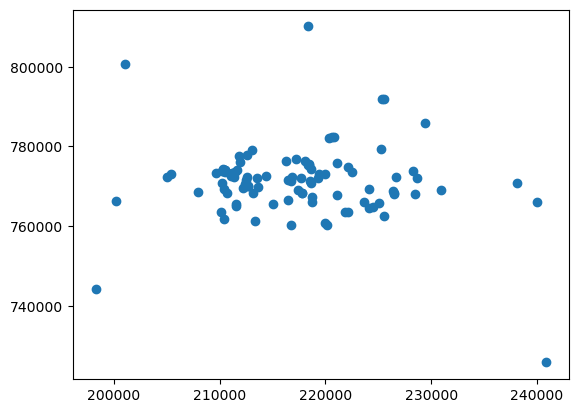

In [222]:
xs = []
ys = []
scores = []
label = []
i=0
for key in ranked:
    score = ranked[key]
    row = sample.loc[sample['id'] == key]
    title = row.iloc[0]['title']
    g = OSGridConverter.latlong2grid (row.iloc[0]['lat'], row.iloc[0]['lon'], tag = 'WGS84')
    xs.append(g.E)
    ys.append(g.N)
    label.append(title)
    scores.append(score)
    if i == n:
        break
    i = i+1
    
plt.scatter(xs, ys,)
plt.show()

In [223]:
fig = px.scatter(x=xs, y=ys, color=scores, hover_data=[label])
fig.show()

In [96]:
class SpatialIndex:
    
    def __init__(self, resolution, sample):
        
        sample.dropna() # Get rid of problematic rows with nas
        
        for i in sample.index:
            try:
                g = OSGridConverter.latlong2grid (sample.at[i, 'lat'], sample.at[i, 'lon'], tag = 'WGS84')
                sample.at[i, 'x'] = g.E
                sample.at[i, 'y'] = g.N
            except ValueError:
                #print("Problem with a document", sample.at[i,'id'])
                sample = sample.drop(i)

        # Now we can set up the parameters for our index        
        self.resolution = resolution

        self.minx = sample['x'].min()
        self.maxx = sample['x'].max()
        self.miny = sample['y'].min()
        self.maxy = sample['y'].max()

        w = self.maxx - self.minx
        h = self.maxy - self.miny

        nc = int(w/self.resolution) + 1
        nr = int(h/self.resolution) + 1

        #print(maxx, minx, maxy, miny)
        #print(nr, nc)

        #Build the spatial index now
        self.spatialIndex = pd.DataFrame(index=range(nc),columns=range(nr))

        #Now we populate the index with document ids
        for index, row in sample.iterrows():
            i = int((row['x'] - self.minx)/self.resolution)
            j = int((row['y'] - self.miny)/self.resolution)
            id = row['id']
    
            #print(row['id'])
            #print(row['x'],row['y'],i,j)
            if pd.isnull(self.spatialIndex.at[i,j]):
                self.spatialIndex.at[i,j] = {id:(row['x'],row['y'])}
            else:
                names = self.spatialIndex.at[i,j]
                names.update({id:(row['x'],row['y'])})
                self.spatialIndex.at[i,j] = names

        
    def rangeQuery(self, dist, point):
        x1 = point[0] - dist/2
        x2 = point[0] + dist/2
        y1 = point[1] - dist/2
        y2 = point[1] + dist/2
    
        i1 = int((x1 - self.minx)/self.resolution)
        j1 = int((y1 - self.miny)/self.resolution)
        i2 = int((x2 - self.minx)/self.resolution) + 1
        j2 = int((y2 - self.miny)/self.resolution) + 1

        # Retrieve only the relevant part of the index
        result = self.spatialIndex.iloc[i1:i2, j1:j2]
        # Turn the data frame into a 1d list
        tlist = result.values.flatten()
        # Remove all the nans
        filtered = filter(lambda i:not(type(i) is float), tlist)
        
        #Rank by distance
        ranked = {}
        for item in filtered:
            for key in item:
                d = si.dist(point, item[key])
                #print(key, item[key], dist)
                ranked[key] = d    
        ranked = dict(sorted(ranked.items(), key = lambda x: x[1], reverse=False))
                
        return ranked
    
    def dist(self, p1, p2):
        #print(p1[0], p1[1], p2[0], p2[1])
        dist = (((p1[0] - p2[0]) ** 2) + ((p1[1] - p2[1]) ** 2)) ** 0.5
        #print(dist)
        return dist

In [2]:
import pandas as pd #To use pandas for elegant data handling
import spacy #Our NLP tools
import math

class Postings:
    
    def __init__(self, firstMondayTerms, sample):
        #Load a language model to do NLP
        self.nlp = spacy.load("en_core_web_md")
        self.ndocs = len(sample)
                
        # firstMonday works like an inverse stop list, and we only use words in these lists for our posting file
        if firstMondayTerms:
            list = {}
            elements = set(pd.read_csv('./data/elements.txt', header=None)[0])
            qualities = set(pd.read_csv('./data/qualities.txt', header=None)[0])
            activities = set(pd.read_csv('./data/activities.txt', header=None)[0])

            terms = elements.union(qualities).union(activities)
            lemmas = ' '.join(str(e) for e in terms)

            doc = self.nlp(lemmas)
            terms = set()
            for token in doc:
                terms.add(token.lemma_)
                
            # Now we process our corpus and create a postings file
            docs = self.nlp.pipe(sample.text,n_process=2, batch_size=100)

            self.postings = dict()

            for (idxRow, s1), (_, s2) in zip(sample.iterrows(), enumerate(docs)):
                id = s1.id
                for token in s2:
                    lemma = token.lemma_
                    if lemma in terms:

                        if lemma in self.postings:
                            tf = self.postings[lemma]
                            if id in tf:
                                tf[id] = tf[id] + 1
                            else:
                                tf[id] = 1
                        else:
                            tf = {id: 1}
                        self.postings[lemma] = tf
                        
    def tfIdf(self, query):
        results = {}
        qdoc = self.nlp(query)
        for token in qdoc:
            qt = token.lemma_
            if qt in self.postings:
                dc = len(self.postings[qt])
                idf = math.log10(self.ndocs/(dc + 1))
                for doc in self.postings[qt]:
                    tf = self.postings[qt][doc]
                    tfidf = tf * idf
                    if doc in results:
                        score = results[doc]
                        results[doc] = tfidf + score
                    else:
                        results[doc] = tfidf
        results = dict(sorted(results.items(), key = lambda x: x[1], reverse=True))
        
        return results

In [3]:
import pandas as pd #To use pandas for elegant data handling
# Feature codes in gazetteer are as follows:
# A Antiquity (non-Roman)
# F Forest or wood
# FM Farm
# H Hill or mountain
# R Antiquity (Roman)
# C City
# T Town
# O Other
# W Water feature
# X All other features

class Gazetteer:
    
    def __init__(self):
        self.gaz = dict()
        self.offset = {'C': 2000, 'T':500, 'H':250, 'F':500}
        # Read in gazetteer data
        os_50k = pd.read_csv('./data/50kgaz2012.txt',sep=':', encoding='utf8', header=None)
        os_trimmed = os_50k.drop([0,1,3,4,5,6,7,10,11,12,15,16,17,18,19], axis = 1)
        os_trimmed.columns = ['name','y','x','county','type']
        for index, row in os_trimmed.iterrows():
            name = row['name']
            entry = os_trimmed.iloc[index].values 
            # Store gazetteer in a dictionary of unique names
            if name in self.gaz:
                entries = self.gaz[name]
                entries.append(entry)
                self.gaz[name] = entries
            else:
                self.gaz[name] = [entry]
            
    def getLocation(self, name):
        if (name in self.gaz) == False:
            return('Name not found in gazetteer')

        if len(self.gaz[name]) > 1:
            # We let the user disambiguate
            i = 0
            print("This place name is ambiguous - choose an entry")
            for entry in self.gaz[name]:
                print(f'{i}: {name}, {entry[3]}')
                i = i + 1
            index = int(input("Choose a value:"))
            entry = self.gaz[name][index]
        else:
            entry = self.gaz[name][0]
            
        print(entry)
        x = entry[2]
        y = entry[1]
            
        if entry[4] in self.offset:
            diff = self.offset[entry[4]]
            return (x,y,x-diff, y-diff, x + diff, y + diff)
        else:
            return(x,y)
                                    
    def gazDump(self):
        for name in self.gaz:
            print(name)
            print(self.gaz[name])
            

In [225]:
#output all dependencies so that we can reproduce the notebook (we only need this to set things up for Binder)
%load_ext watermark
%watermark --iversions

spacy          : 3.3.1
matplotlib     : 3.5.2
OSGridConverter: 0.1.3
pandas         : 1.4.4
numpy          : 1.21.5
plotly         : 5.9.0

